## Overview notebook from Ivan's Cruise (Aug 24-29)

This notebook pulls in some of the major data streams and visualizes them together along with GOES SST imagery from around the time of each transect.

In [1]:
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd

import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

Pull in the TSG data

This data is available every second but using the per minute one here

In [3]:
nav_df = pd.read_csv('data/feb_cruise/SW22002R_NRL01/Navigation/SW-GGA_20220130-213023.Raw',  names=['Date', 'Time', 'GPGGA','Unknown', 'SW-GGA-Lat', 'latdir', 'SW-GGA-Long', 'londir', '1', '2', '3', '4', '5', '6', '7'])

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

nav_df['lon'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
nav_df['lat'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

date_time_strs = nav_df['Date'] + ' ' + nav_df['Time']

nav_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f') for x in date_time_strs]
nav_df['utc_dt'] = nav_df['datetime']
nav_df  = nav_df.set_index('utc_dt')
tsg_df = pd.read_csv('data/feb_cruise/SW22002R_NRL01/FlowThru/TSG-_20220130-213023.Raw', names=['DateTime', 'Temp','Sal','Unknown'], delim_whitespace=True)#sep=r"s*")# names=['Date', 'Time', 'Data'])
tsg_df
tsg_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y,%H:%M:%S.%f') for x in tsg_df.DateTime]

lats = []
lons = []
for i in range(len(tsg_df)):
    row = nav_df.iloc[nav_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
tsg_df['lat'] = lats
tsg_df['lon'] = lons

tsg_df['utc_dt'] = tsg_df['datetime']
tsg_df  = tsg_df.set_index('utc_dt')

In [10]:
nav_df = pd.read_csv('data/feb_cruise/SW22002R_NRL01/Navigation/SW-GGA_20220130-213023.Raw',  names=['Date', 'Time', 'GPGGA','Unknown', 'SW-GGA-Lat', 'latdir', 'SW-GGA-Long', 'londir', '1', '2', '3', '4', '5', '6', '7'])

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

nav_df['lon'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
nav_df['lat'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

date_time_strs = nav_df['Date'] + ' ' + nav_df['Time']

nav_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f') for x in date_time_strs]
nav_df['utc_dt'] = nav_df['datetime']
nav_df  = nav_df.set_index('utc_dt')


tsg_df = pd.read_csv('data/feb_cruise/SW22002R_NRL01/FlowThru/TSG-_20220130-213023.Raw', names=['DateTime', 'Temp','Sal','Unknown'], delim_whitespace=True)#sep=r"s*")# names=['Date', 'Time', 'Data'])
tsg_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y,%H:%M:%S.%f') for x in tsg_df.DateTime]

chla_df = pd.read_csv('data/feb_cruise/SW22002R_NRL01/FlowThru/FluorometerWETStar-Chlorophyll-DRV_20220130-213023.Raw', 
                      index_col=False,
                      names=['Date','Time','VarName','Chla','Volts'], sep=",")

chla_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y%H:%M:%S.%f') for x in chla_df.Date+chla_df.Time]
chla_df['utc_dt'] = chla_df['datetime']
chla_df  = chla_df.set_index('utc_dt')

lats = []
lons = []
chla = []
for i in range(len(tsg_df)):
    row = nav_df.iloc[nav_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    row = chla_df.iloc[chla_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    chla.append(row.Chla)
    
tsg_df['lat'] = lats
tsg_df['lon'] = lons
tsg_df['chla'] = chla

tsg_df['utc_dt'] = tsg_df['datetime']
tsg_df  = tsg_df.set_index('utc_dt')

tsg_df = tsg_df.sort_index(ascending=True)

In [12]:
len(tsg_df)

32225

<AxesSubplot:>

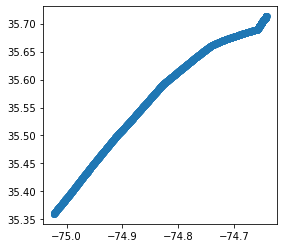

In [13]:
gdf = gpd.GeoDataFrame(
    tsg_df, geometry=gpd.points_from_xy(tsg_df.lon, tsg_df.lat))
gdf.loc['2022-02-01 8:00:00':'2022-02-01 12:45:00'].plot()

<AxesSubplot:>

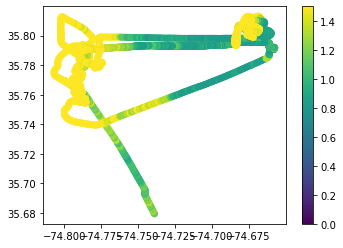

In [15]:
gdf.loc['2022-02-02 12:00:00':'2022-02-02 18:45:00'].plot(column='chla',legend=True, vmin=0,vmax=1.5)

<AxesSubplot:>

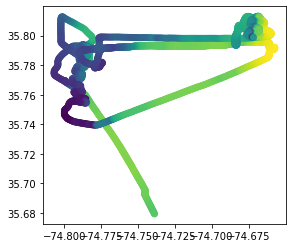

In [18]:
gdf_subset = gdf.loc['2022-02-02 12:00:00':'2022-02-02 18:45:00']
gdf_subset.plot(column='Temp')

<AxesSubplot:>

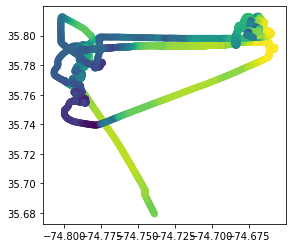

In [19]:
gdf_subset.plot(column='Sal')

<AxesSubplot:>

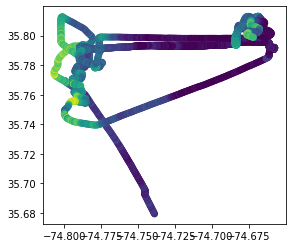

In [20]:
gdf_subset.plot(column='chla')

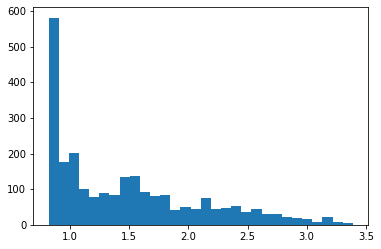

In [28]:
plt.hist(gdf_subset['chla'],bins=30)
plt.show()

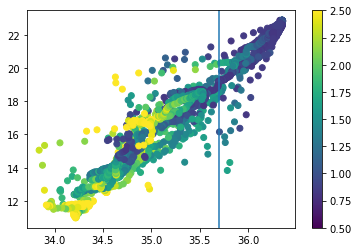

In [29]:
fig, ax = plt.subplots()

sc = ax.scatter(gdf_subset['Sal'], gdf_subset['Temp'], c=gdf_subset['chla'], vmin=.5,vmax=2.5)
ax.axvline(35.7)
fig.colorbar(sc)

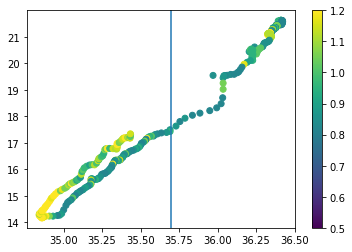

In [42]:
tsg_subset = tsg_df.loc['2022-01-31 16:55:00':'2022-01-31 18:30:00']
fig, ax = plt.subplots()

sc = ax.scatter(tsg_subset['Sal'], tsg_subset['Temp'], c=tsg_subset['chla'], vmin=.5,vmax=1.2)
ax.axvline(35.7)
fig.colorbar(sc)

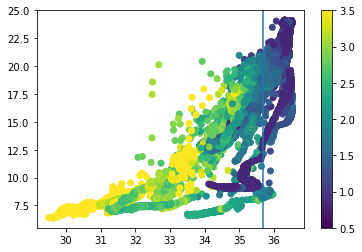

In [22]:
fig, ax = plt.subplots()

sc = ax.scatter(gdf['Sal'], gdf['Temp'], c=gdf['chla'], vmin=.5,vmax=3.5)
ax.axvline(35.7)
fig.colorbar(sc)

#### Grab the sample data to overlay and add to

In [159]:
samples_df = pd.read_csv('data/feb_cruise/GSF_Sampling_Table_tidy.csv')
samples_df['datetime'] = [datetime.strptime(x[:-1], '%d-%b-%y %H:%M:%S') for x in samples_df.Date+' '+samples_df['Ship Time']]
samples_df['utc_dt'] = samples_df['datetime']
samples_df  = samples_df.set_index('utc_dt')

In [160]:
lats = []
lons = []
chlas = []
sals = []
temps = []

for i in range(len(samples_df)):
    row = tsg_df.iloc[tsg_df.index.get_loc(samples_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    chlas.append(row.chla)
    sals.append(row.Sal)
    temps.append(row.Temp)
    
samples_df['lat'] = lats
samples_df['lon'] = lons
samples_df['chla'] = chlas
samples_df['sal'] = sals
samples_df['temp'] = temps

In [161]:
samples_df.head()

Cruise  Transect  Stations       Date Ship Time  FCM  \
utc_dt                                                                     
2022-01-31 16:58:04    Feb         2         1  31-Jan-22  16:58:42    1   
2022-01-31 17:42:02    Feb         2         2  31-Jan-22  17:42:24    1   
2022-01-31 18:04:01    Feb         2         3  31-Jan-22  18:04:15    1   
2022-01-31 18:35:02    Feb         2         4  31-Jan-22  18:35:25    1   
2022-02-02 15:05:00    Feb         4         1   2-Feb-22  15:05:01    1   

                     Nutrients  Viromics  Microscopy   16S/18S  \
utc_dt                                                           
2022-01-31 16:58:04          1         1            1        0   
2022-01-31 17:42:02          1         1            1        0   
2022-01-31 18:04:01          1         0            1        0   
2022-01-31 18:35:02          1         1            1        0   
2022-02-02 15:05:00          1         0            0        0   

                           Category            datetime        lat        lon  \
utc_dt                                                                          
2022-01-31 16:58:04     Gulf Stream 2022-01-31 16:58:04  35.732742 -74.662510   
2022-01-31 17:42:02     Gulf Stream 2022-01-31 17:42:02  35.768110 -74.670398   
2022-01-31 18:04:01  Front/Filament 2022-01-31 18:04:01  35.774088 -74.682075   
2022-01-31 18:35:02  Front/Filament 2022-01-31 18:35:02  35.781230 -74.707698   
2022-02-02 15:05:00     Gulf Stream 2022-02-02 15:05:00  35.795498 -74.665075   

                     chla      sal     temp  
utc_dt                                       
2022-01-31 16:58:04  0.92  36.4169  21.5650  
2022-01-31 17:42:02  1.10  36.3531  21.2498  
2022-01-31 18:04:01  0.85  35.4174  16.6198  
2022-01-31 18:35:02  1.20  35.5147  17.7913  
2022-02-02 15:05:00  0.82  36.3523  22.5708

In [184]:
samples_df.to_csv('GSF_Sampling_Table_tidy_combined_feb.csv')

<AxesSubplot:>

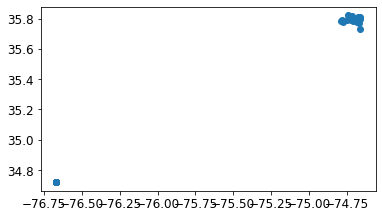

In [162]:
samples_gdf = gpd.GeoDataFrame(
    samples_df, geometry=gpd.points_from_xy(samples_df.lon, samples_df.lat))
samples_gdf.plot()

#### Add in density and density grad

In [179]:
tsg_df['Sal_smooth'] = tsg_df.Sal.rolling(window=7).median()
tsg_df['Temp_smooth'] = tsg_df.Temp.rolling(window=7).median()

In [180]:
import gsw
tsg_df['sigma'] = gsw.density.sigma0(tsg_df.Sal_smooth, tsg_df.Temp_smooth).rolling(window=5).mean()
tsg_df['sigma_grad'] = np.gradient(tsg_df['sigma'])

In [84]:
?gsw.density.sigma0

In [85]:
tsg_df.head()

DateTime    Temp      Sal  Unknown  \
utc_dt                                                                        
2022-01-30 21:30:24.351  01/30/2022,21:30:24.351,  6.7048  33.5133  1475.94   
2022-01-30 21:30:34.335  01/30/2022,21:30:34.335,  6.6977  33.5127  1475.91   
2022-01-30 21:30:44.334  01/30/2022,21:30:44.334,  6.6809  33.5143  1475.85   
2022-01-30 21:30:54.335  01/30/2022,21:30:54.335,  6.6905  33.5177  1475.89   
2022-01-30 21:31:04.335  01/30/2022,21:31:04.335,  6.6670  33.5182  1475.80   

                                       datetime        lat        lon  chla  \
utc_dt                                                                        
2022-01-30 21:30:24.351 2022-01-30 21:30:24.351  34.717575 -76.670578  2.39   
2022-01-30 21:30:34.335 2022-01-30 21:30:34.335  34.717570 -76.670578  2.39   
2022-01-30 21:30:44.334 2022-01-30 21:30:44.334  34.717568 -76.670575  2.34   
2022-01-30 21:30:54.335 2022-01-30 21:30:54.335  34.717568 -76.670577  2.44   
2022-01-30 21:31:04.335 2022-01-30 21:31:04.335  34.717568 -76.670577  2.39   

                                           geometry      sigma  sigma_grad  
utc_dt                                                                      
2022-01-30 21:30:24.351  POINT (-76.67058 34.71757)        NaN         NaN  
2022-01-30 21:30:34.335  POINT (-76.67058 34.71757)        NaN         NaN  
2022-01-30 21:30:44.334  POINT (-76.67057 34.71757)        NaN         NaN  
2022-01-30 21:30:54.335  POINT (-76.67058 34.71757)        NaN         NaN  
2022-01-30 21:31:04.335  POINT (-76.67058 34.71757)  26.170256         NaN

In [87]:
tsg_df.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

Cutting the whole dataset up into transects by visualizing them like this.

In [134]:
tsg_df.loc['2022-02-02 15:05:00':'2022-02-02 17:00:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,tiles='EsriNatGeo', width=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [135]:
start_times = ['2022-01-31 16:55:00','2022-02-02 15:05:00','2022-02-02 19:35:00'] 
end_times = ['2022-01-31 18:55:00','2022-02-02 17:10:30','2022-02-02 21:05:00']

In [167]:
plt.rcParams.update({'font.size': 14})

In [174]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b %d %y - %H:%M')

<ipython-input-182-7e3a0d49d609>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-182-7e3a0d49d609>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-182-7e3a0d49d609>:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')


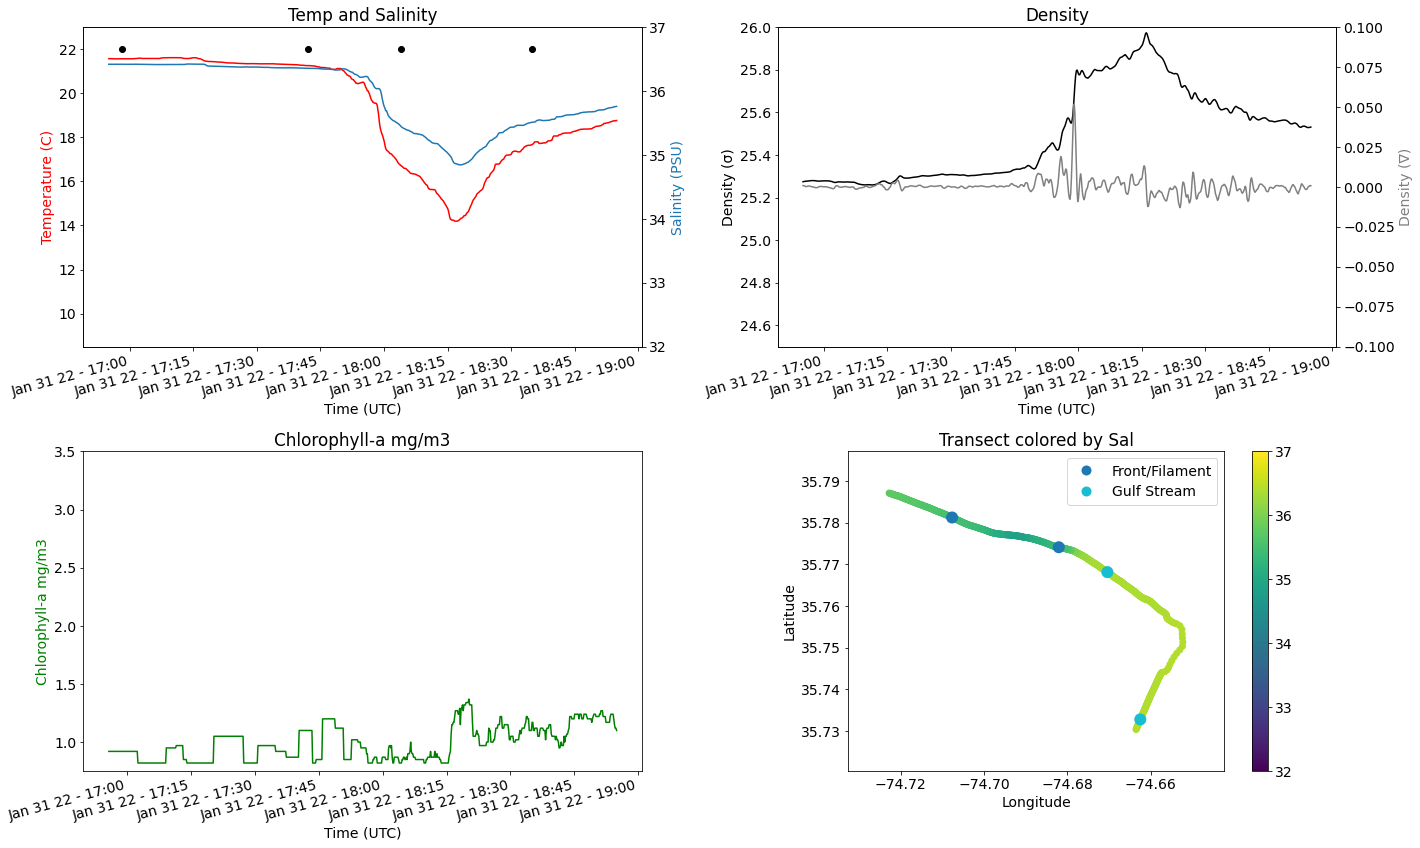

----------------------------------------------------------------------------------------------------------


<ipython-input-182-7e3a0d49d609>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-182-7e3a0d49d609>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-182-7e3a0d49d609>:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')


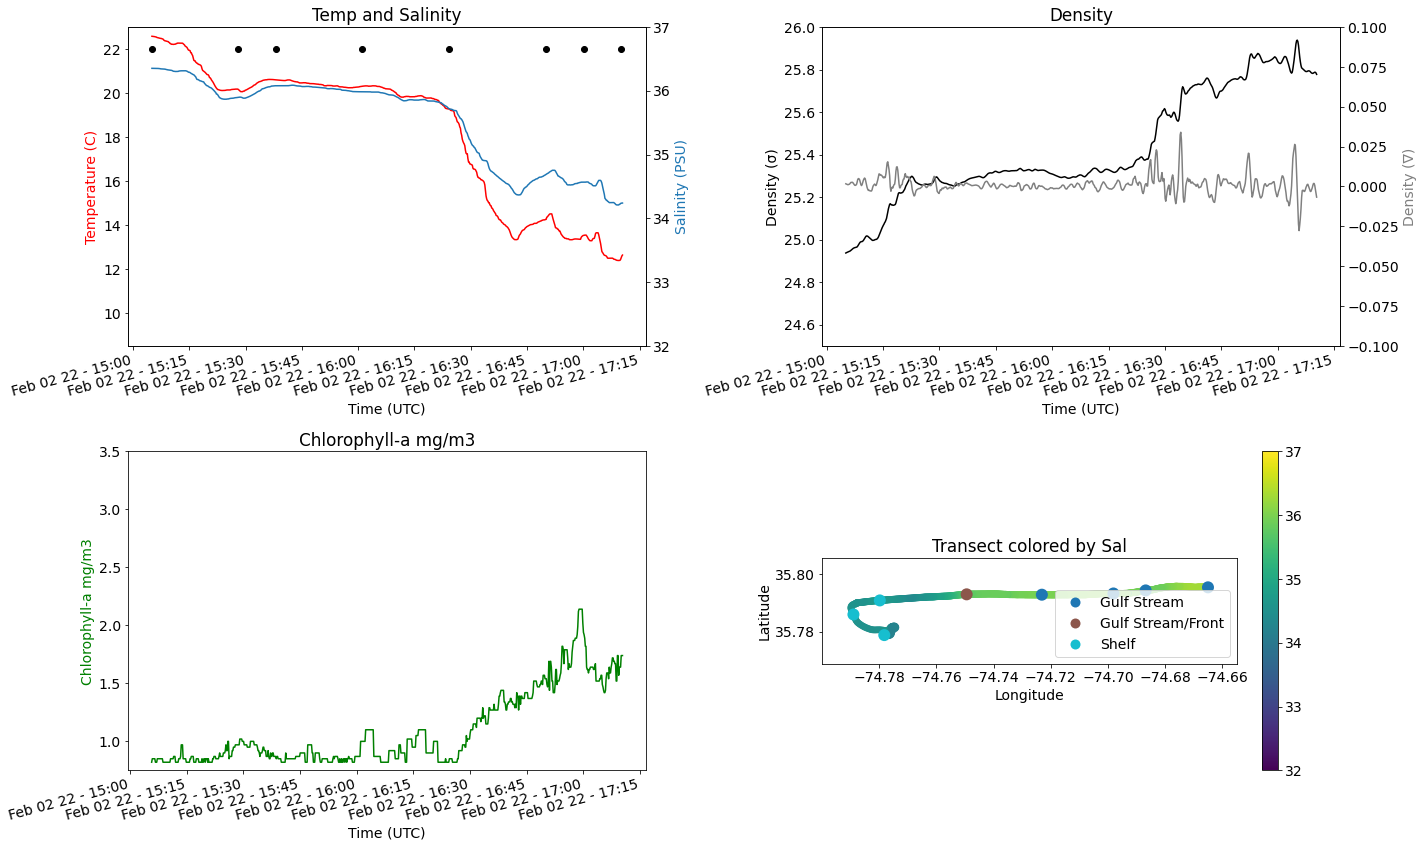

----------------------------------------------------------------------------------------------------------


<ipython-input-182-7e3a0d49d609>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-182-7e3a0d49d609>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-182-7e3a0d49d609>:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')


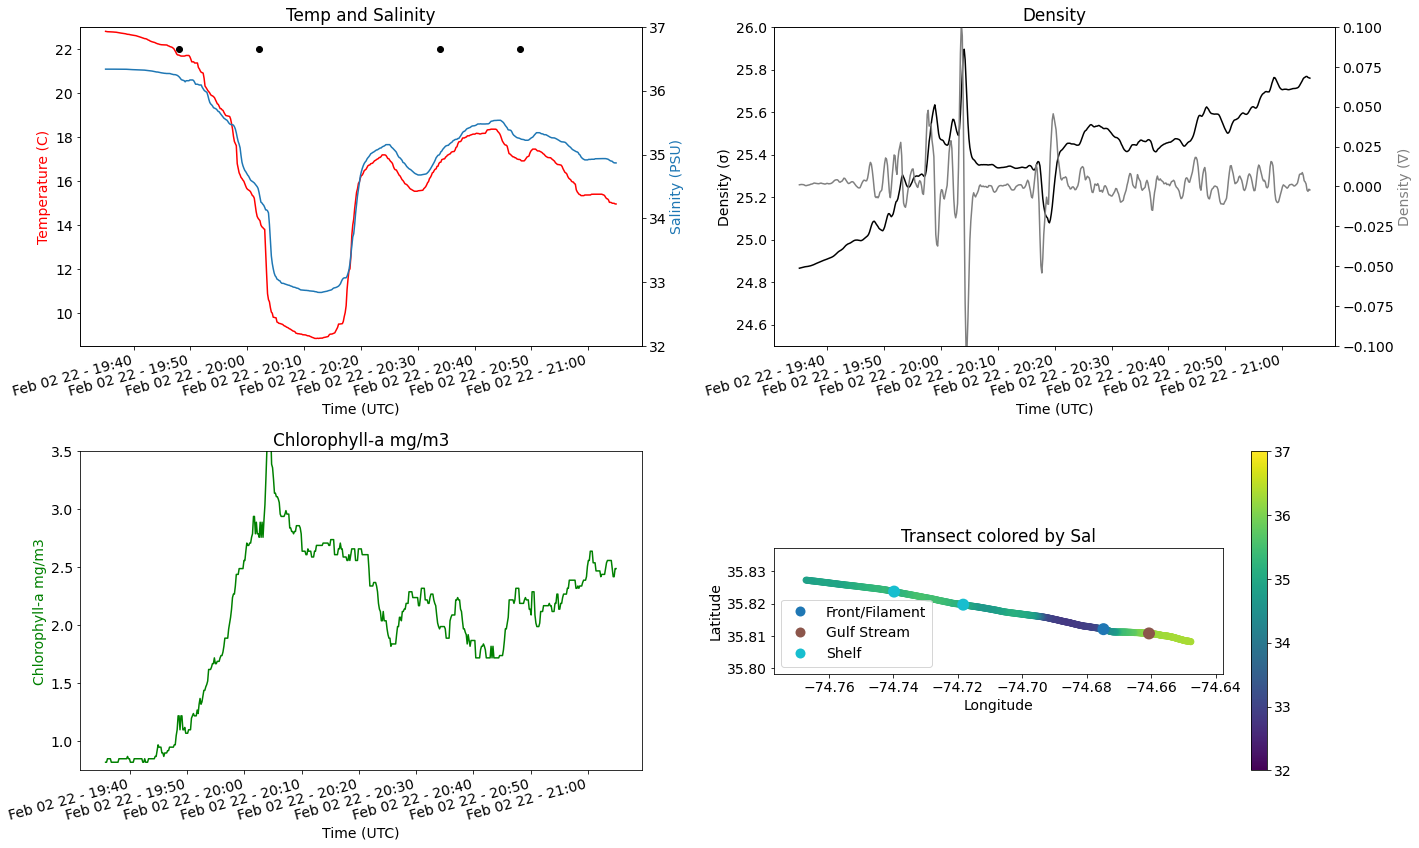

----------------------------------------------------------------------------------------------------------


In [182]:
titles = ['Feb 2022 T2','Feb 2022 T4','Feb 2022 T5']
for i in range(3):
# for i in [0,1,4,5,8]:
        # time series plot
        fig = plt.figure(figsize=(20,12))

        gs = fig.add_gridspec(2,2)
        
        temp_ax = fig.add_subplot(gs[0, 0]) # S/T
        density_ax = fig.add_subplot(gs[0, 1]) # density
        chla_ax = fig.add_subplot(gs[1, 0])
        map_ax = fig.add_subplot(gs[1, 1])
    
        sal_ax = temp_ax.twinx()
        density_grad_ax = density_ax.twinx()
        
        
        temp_ax.set_ylim(8.5, 23)
        sal_ax.set_ylim(32, 37)
        chla_ax.set_ylim(.75, 3.5)
        density_ax.set_ylim(24.5, 26)
        density_grad_ax.set_ylim(-.1, .1)
        
#         ax.set_xlabel("Time (UTC)")
        temp_ax.set_title("Temp and Salinity")
        temp_ax.set_ylabel("Temperature (C)")
        sal_ax.set_ylabel("Salinity (PSU)")

        chla_ax.set_title("Chlorophyll-a mg/m3")
        chla_ax.set_ylabel("Chlorophyll-a mg/m3")
        
        
        density_ax.set_title('Density')
        density_ax.set_ylabel('Density (σ)')
        density_grad_ax.set_ylabel('Density (∇)')
        
        temp_ax.set_xlabel("Time (UTC)")
        density_ax.set_xlabel("Time (UTC)")
        chla_ax.set_xlabel("Time (UTC)")
        
        map_ax.set_title('Transect colored by Sal')
        map_ax.set_ylabel('Latitude')
        map_ax.set_xlabel('Longitude')
        map_ax.ticklabel_format(useOffset=False)
        
        
        sample_len = len(samples_df.loc[start_times[i]:end_times[i]].index)
        temp_ax.scatter(samples_df.loc[start_times[i]:end_times[i]].index, [22]*sample_len, color='black', label='Sample')

        p1, = temp_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp_smooth'], color='red', label='Temp')
        p2, = sal_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal_smooth'], label='Salinity')
        
        p3, = density_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)',  color='black')
        p4, = density_grad_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma_grad'], label='Density (sigma)',  color='grey')

        p5, = chla_ax.plot(tsg_df[tsg_df['chla'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['chla'].notnull()].loc[start_times[i]:end_times[i]]['chla'].rolling(window=5).median(), label='Chla mg/m3', color='green')
        
        gdf_subset = gdf.loc[start_times[i]:end_times[i]]
        gdf_subset.plot(column='Sal',ax=map_ax, legend=True, vmin=32, vmax=37)
        
        samples_gdf_subset = samples_gdf.loc[start_times[i]:end_times[i]]
        samples_gdf_subset.plot('Category',ax=map_ax,lw=2, legend=True, facecolor='none', s=100)
        
        map_ax.set_ylim(gdf_subset.lat.min()-0.01, gdf_subset.lat.max()+0.01)
        map_ax.set_xlim(gdf_subset.lon.min()-0.01, gdf_subset.lon.max()+0.01)
        
        temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
        density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
        chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')

        temp_ax.xaxis.set_major_formatter(myFmt)
        density_ax.xaxis.set_major_formatter(myFmt)
        chla_ax.xaxis.set_major_formatter(myFmt)

        temp_ax.yaxis.label.set_color(p1.get_color())
        sal_ax.yaxis.label.set_color(p2.get_color())
        density_ax.yaxis.label.set_color(p3.get_color())
        density_grad_ax.yaxis.label.set_color(p4.get_color())
        chla_ax.yaxis.label.set_color(p5.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
        fig.savefig('figs/feb_transects'+titles[i] +'.png',dpi=600)
    #     plt.close()
        plt.show()
        print('----------------------------------------------------------------------------------------------------------')
        
#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)
        
#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/s_t_diagram'+titles[i] +'.png')
#         fig.colorbar(sc)

### Some T-S Diagrams

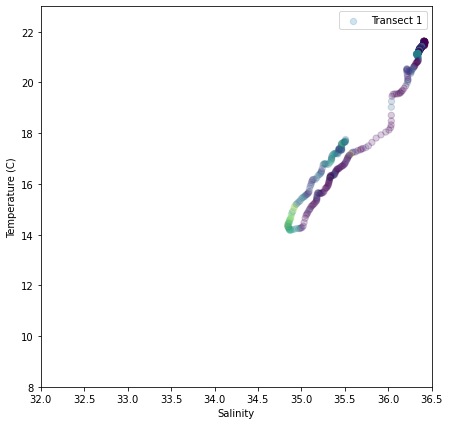

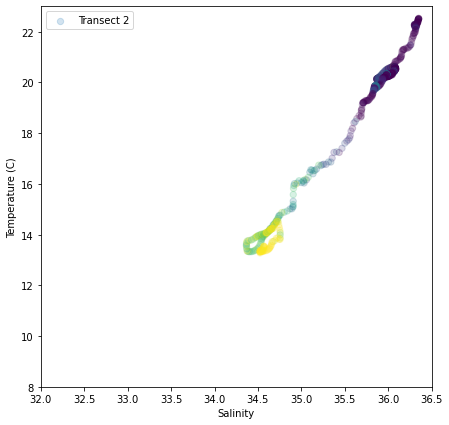

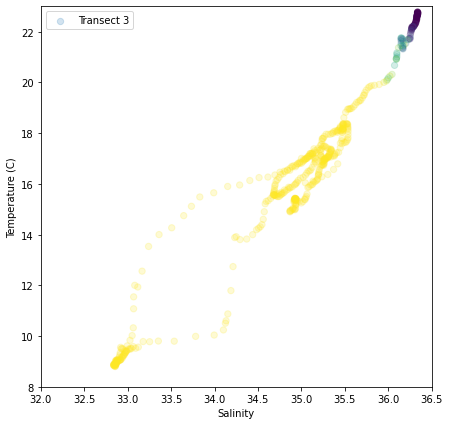

In [123]:
# Figure out boudaries (mins and maxs)
smin = 32
smax = 36.5
tmin = 8
tmax = 23

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000


for i in range(len(start_times)):
    # plot T and S diagrams first with distance from coast and then with other variables
    fig, ax = plt.subplots(figsize=(7,7))
    markersize=40

    ax.set_xlim(32,36.5)
    ax.set_ylim(8,23)
    ax.set_xlabel('Salinity')
    ax.set_ylabel('Temperature (C)')

    # CS = a.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.5)
    # a.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
    # ellipse = Ellipse(xy=(35.88, 28.05), width=0.5, height=1.2, angle=-20,
    #                 edgecolor='k', fc='None', ls='--', lw=2)
    # ax.add_patch(ellipse)
    alpha=0.2

    # im = ax.scatter(tsg_df_subset.Sal, tsg_df_subset.Temp, s=markersize,alpha=0.2, c=tsg_df_subset.chla, label='Chla')
    # ax.legend()


    df_subset_full = tsg_df.loc[start_times[i]:end_times[i]]
    im = ax.scatter(df_subset_full.Sal.rolling(window=6).median(), df_subset_full.Temp, c=df_subset_full.chla, vmin=.85,vmax=1.5, s=markersize,alpha=0.2, label='Transect '+str(i+1))
    ax.legend()
    # fig.savefig('figs/simple_t_s_diagram_all_transects.png',dpi=300)
    plt.show()


### Profile Data

In [49]:
import scipy.io


In [50]:
names=['c1t1', 'c1t2', 'c1t3', 'c1t4', 'c1t5', 'c1t6', 'c1t7', 'c1t8']
li = []
for i, fn in enumerate(glob.glob("data/VMP/Cruise1/*.mat")):
    mat = scipy.io.loadmat(fn)
    for item in list(mat.keys()):
        if item not in ['__header__', '__version__', '__globals__']:
            df = pd.DataFrame(data=mat[item], columns=['time', 'depth (dBars)', 'temp (C)','salinity (PSU)', 'potential density (kg/m^3 -1000)', 
                                                    'chla (ppb)', 'turbidity (FTU)', 'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)'])
            df['transect'] = names[i]
            df['profile_num'] = item.split('profile')[-1]
            li.append(df)

profiles = pd.concat(li, axis=0, ignore_index=True)
profiles['dt'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles.time, unit='D') - pd.Timedelta(days=1)
profiles = profiles.set_index('dt')
profiles = profiles.sort_index(ascending=True)
profiles['datetime'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles.time, unit='D') - pd.Timedelta(days=1)

In [60]:
profiles['profile_num'] = profiles.profile_num.astype(int)

In [61]:
import numpy as np
# from scipy.interpolate import interp2d
import scipy


data_variables = ['temp (C)', 'salinity (PSU)',
       'potential density (kg/m^3 -1000)', 'chla (ppb)', 'turbidity (FTU)',
       'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)']

def interpolate_profiles(df, transect, data_variables, plot=False):
    df_subset = df[df.transect == transect]
    interpolated_grids = []
    datetime_list = []
    for i in np.unique(df_subset.profile_num.values):
        datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
    datetime_list = np.array(datetime_list)
    datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
    
    # Original data (e.g. measurements)
    for data_var in data_variables:
        x_interp = np.arange(1,len(datetime_list), .5)
        y_interp = np.arange(-1,-115, -1)

        xx, yy = np.meshgrid(x_interp, y_interp)
        Z_table = df_subset[data_var].values

        Z = scipy.interpolate.griddata(np.array(list(zip(df_subset.profile_num.values , df_subset['depth (dBars)'].values ))), Z_table, (xx, yy), method='linear')

        datetime_list = []
        for i in np.unique(df_subset.profile_num.values):
            datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
        datetime_list = np.array(datetime_list)
        datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
        
        interpolated_grids.append(Z)

        if plot:
            fig, ax = plt.subplots(figsize=(12,7))
#             im = ax.imshow(Z, aspect='auto', cmap='viridis_r', vmax=22.2, vmin=26.8)
#             im = ax.imshow(Z, aspect='auto', cmap='cividis', vmax=-0.4, vmin=.25)
            im = ax.imshow(Z, aspect='auto', cmap='jet')#, vmax=-0.4, vmin=.25)

            cb = fig.colorbar(im)
            cb.set_label(data_var)

            ax.set(xticks=np.arange(0,np.max(df_subset.profile_num.values)*2-1,2), 
                   xticklabels=[x[6:].replace('T', ' ') for x in np.datetime_as_string(datetime_list.flatten(), unit='m')])

            ax.set_ylabel('Depth (m)')
            ax.set_xlabel('Time (UTC)')
            fig.autofmt_xdate(rotation=45)
            ax.xaxis.set_major_locator(plt.MaxNLocator(15))

#             fig.savefig('transect5_profile_sal.png')
            plt.show()
    return(datetime_list, interpolated_grids)

In [62]:
transect_names=['c1t1', 'c1t2', 'c1t3', 'c1t4', 'c1t5', 'c1t6', 'c1t7', 'c1t8']

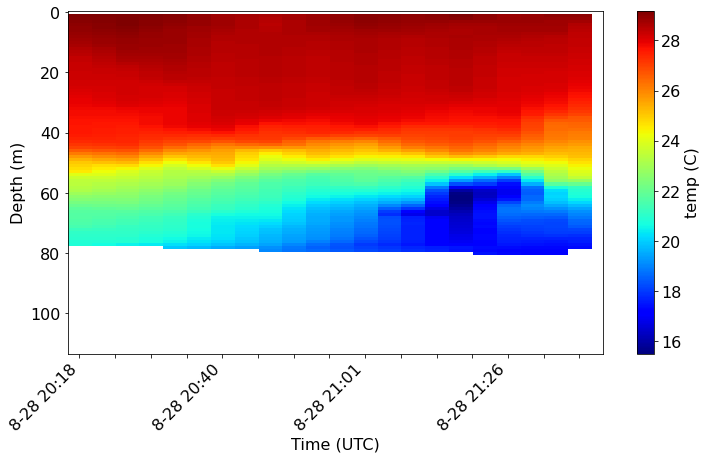

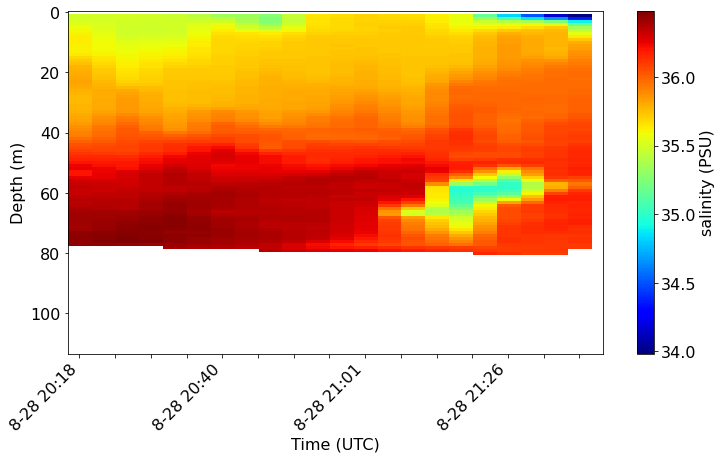

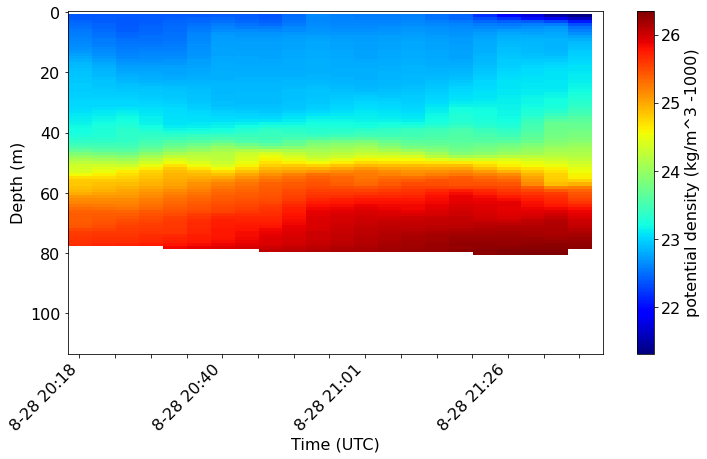

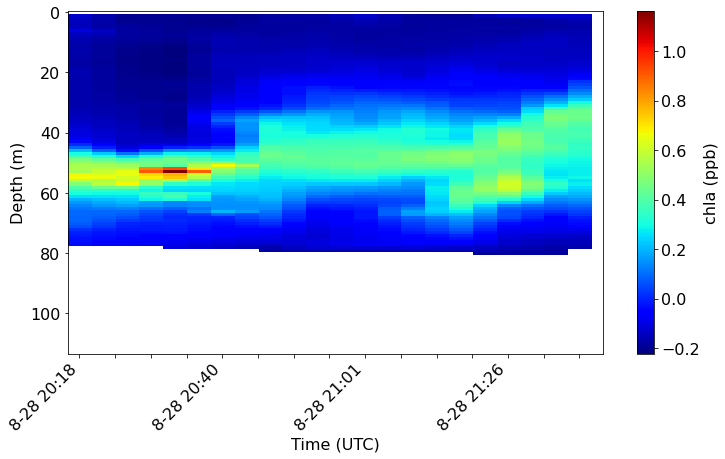

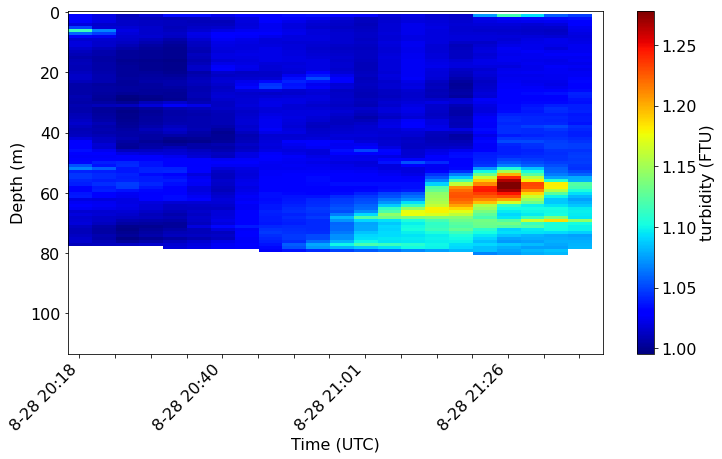

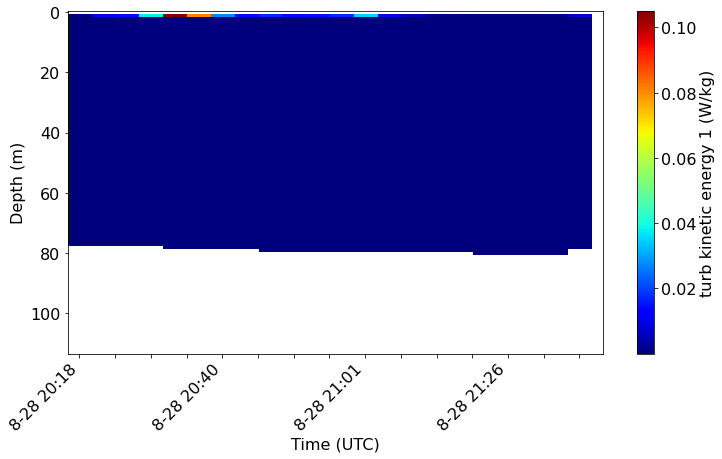

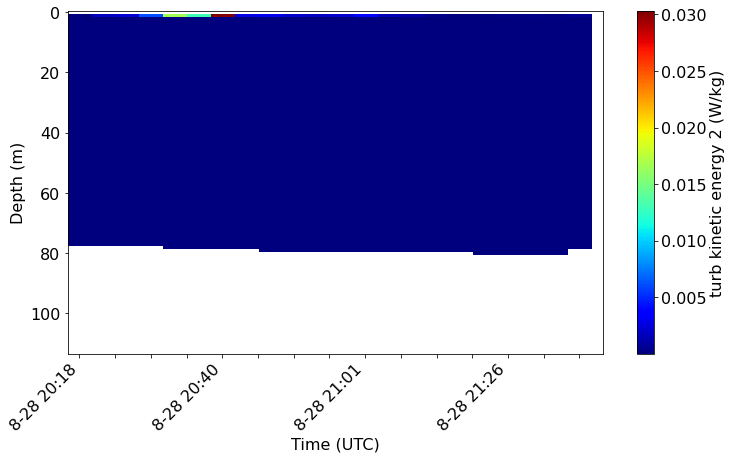

In [72]:
dates, interpolated_grids = interpolate_profiles(profiles, transect_names[5], data_variables, plot=True)

#### Visualizing SST from GOES

In [19]:
goes_ds = xr.open_dataset('data/jplStarG16SSTv270_8997_d932_2101.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [22]:
goes_ds.sea_surface_temperature[:,:, :].resample(time="6H", skipna=True).mean().hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-08-27 11:00:00':'2021-08-29 13:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

In [20]:
start_times = ['2021-08-26 12:15:00', '2021-08-27 11:38:00', '2021-08-27 16:09:00', '2021-08-27 18:30:00', '2021-08-27 22:25:00', '2021-08-28 10:50:00',
               '2021-08-28 13:48:00', '2021-08-28 15:08:00', '2021-08-28 18:31:00', '2021-08-28 20:16:00', '2021-08-29 11:10:00', '2021-08-29 14:39:00',
               '2021-08-29 16:15:00']


end_times   = ['2021-08-26 14:12:00', '2021-08-27 12:52:00', '2021-08-27 17:40:00', '2021-08-27 18:45:00', '2021-08-27 23:35:00', '2021-08-28 12:05:00',
               '2021-08-28 14:05:00', '2021-08-28 16:48:00', '2021-08-28 18:56:00', '2021-08-28 21:50:00', '2021-08-29 13:40:00', '2021-08-29 15:00:00',
               '2021-08-29 17:52:00']

In [27]:
plt.rcParams.update({'font.size': 16})

In [39]:
start_times[i]

'2021-08-27 16:09:00'

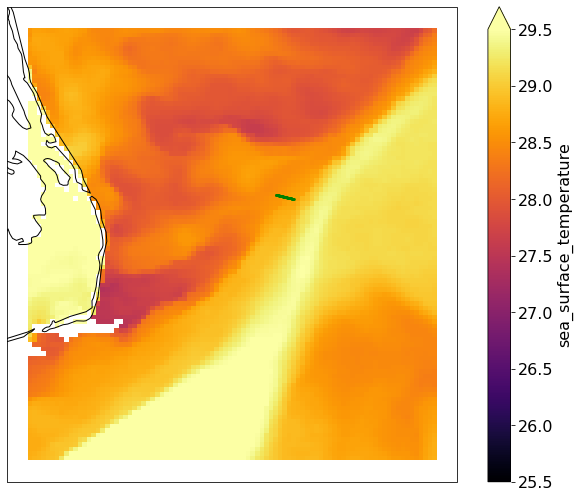

In [40]:
i=2
fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=1), pd.to_datetime(end_times[i])+timedelta(hours=1))).sea_surface_temperature[:,75:170, 110:200].mean(dim='time').plot(ax=ax, vmin=25.5, vmax=29.5, cmap='inferno')

gdf.loc[start_times[i]:end_times[i]].plot(ax=ax, markersize=3, color='green', alpha=.5)

fig.savefig('sst_aug2716_studypoints.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

## Plot each transect with data and SST satellite imagery

In [23]:
plt.rcParams.update({'font.size': 14})

I manually went through the data and found all these start and stop times based on the ships location and our logs. They could have errors in them but I tried to be very precise.

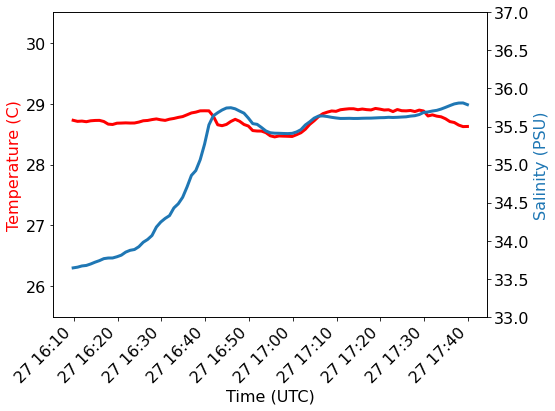

In [47]:
start_times = ['2021-08-26 12:15:00', '2021-08-27 11:38:00', '2021-08-27 16:09:00', '2021-08-27 18:30:00', '2021-08-27 22:25:00', '2021-08-28 10:50:00',
               '2021-08-28 13:48:00', '2021-08-28 15:08:00', '2021-08-28 18:31:00', '2021-08-28 20:16:00', '2021-08-29 11:10:00', '2021-08-29 14:39:00',
               '2021-08-29 16:15:00']


end_times   = ['2021-08-26 14:12:00', '2021-08-27 12:52:00', '2021-08-27 17:40:00', '2021-08-27 18:45:00', '2021-08-27 23:35:00', '2021-08-28 12:05:00',
               '2021-08-28 14:05:00', '2021-08-28 16:48:00', '2021-08-28 18:56:00', '2021-08-28 21:50:00', '2021-08-29 13:40:00', '2021-08-29 15:00:00',
               '2021-08-29 17:52:00']

hours = [0,0,0,1,0,0,0,0,0,0,4,4,4]

titles = ['Transect 1', 'Transect 2', 'Transect 3', 'Transect 4', 
        'Transect 5', 'Transect 6', 'Transect 7', 'Transect 8',
        'Transect 9', 'Transect 10', 'Transect 11', 'Transect 12', 'Transect 13']

for i in [2]:
    # time series plot
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax1 = ax.twinx()
#     ax2 = ax.twinx()
#     ax3 = ax.twinx()

    ax.set_ylim(25.5, 30.5)
    ax1.set_ylim(33, 37)
#     ax2.set_ylim(.0, .20)
#     ax3.set_ylim(.0, .40)

    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Temperature (C)")
    ax1.set_ylabel("Salinity (PSU)")
#     ax2.set_ylabel("CDOM (volts)")
#     ax3.set_ylabel("Chla (mg/m3)")

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)
    
    p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'].iloc[::-1], color='red', label='Temp', lw=3)
    p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--sal'].iloc[::-1], label='Salinity', lw=3)
#     p3  = ax2.scatter(cdom_df.loc[start_times[i]:end_times[i]].index, cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean()['cdom_volts'], color='brown', label='CDOM', s=1)
    
    if trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*3).mean()['chla_oci'].empty:
        trios_data_x = None
        trios_data_y = None
    else:
        trios_data_x = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean().index
        trios_data_y = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean()['chla_oci']
#     p4  = ax3.scatter(trios_data_x, trios_data_y, color='green', label='CHla', s=1)
    
#     ax.set_title(titles[i])


#     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
#     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
#     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

    lns = [p1, p2]
#     lns = [p1, p2, p3, p4]
#     ax.legend(handles=lns, loc='best')

    # right, left, top, bottom
#     ax2.spines['right'].set_position(('outward', 70))
    
#     ax3.spines['right'].set_position(('outward', 150))

    # no x-ticks                 
#     ax2.xaxis.set_ticks([])
    fig.autofmt_xdate(rotation=45)

    # Sometimes handy, same for xaxis
    #par2.yaxis.set_ticks_position('right')

    # Move "Velocity"-axis to the left
    # par2.spines['left'].set_position(('outward', 60))
    # par2.spines['left'].set_visible(True)
    # par2.yaxis.set_label_position('left')
    # par2.yaxis.set_ticks_position('left')

    ax.yaxis.label.set_color(p1.get_color())
    ax1.yaxis.label.set_color(p2.get_color())
#     ax2.yaxis.label.set_color('brown')
#     ax3.yaxis.label.set_color('green')

    # Adjust spacings w.r.t. figsize
    fig.tight_layout()
    fig.savefig('figs/'+titles[i] +'.png')
#     plt.close()
    plt.show()
    break
    
    
    
#     # SST image
    
#     fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
#     ax[0].coastlines(resolution='10m')
#     goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
#     gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green', alpha=.05)
    
#     ax[1].coastlines(resolution='10m')
#     goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,75:175, 100:200].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
#     gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.05)
#     # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
#     ax[0].set_title(titles[i] + ' overview')
#     ax[1].set_title(titles[i] + ' zoom')
#     fig.tight_layout()
# #     fig.savefig('figs/'+titles[i] +'sat_overview.png')
# #     plt.close()
#     plt.show()    

#     # fig.savefig('transect' + str(i) '_s_t.png')